In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [92]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Optical absorption of the AGSL5

We study the optical absorption spectrum of the AGSL5.

## IP absorption on top of the DFT analysis

We study the absorption spectrum on top of the DFT analysis in function of the k-points sampling.

In [76]:
kvalues = [10,15,20,25]

In [77]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,10] # eV
damping = [0.1,0.1] # eV
BLongDir = [1.0,0.0,0.0]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir)
    idd = 'abs-ip-xPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 2 parallel tasks


In [78]:
#study.runs[0]

In [79]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
delete job_out script: MB_analysis/kpoints_10x20-nbnds_35/job_abs-ip-xPol-kpoints_10x20.out
delete folder: MB_analysis/kpoints_10x20-nbnds_35/abs-ip-xPol-kpoints_10x20
run command: mpirun -np 16 yambo -F abs-ip-xPol-kpoints_10x20.in -J abs-ip-xPol-kpoints_10x20 -C abs-ip-xPol-kpoints_10x20
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_35 ; sbatch job_abs-ip-xPol-kpoints_10x20.sh
delete job_out script: MB_analysis/kpoints_15x30-nbnds_35/job_abs-ip-xPol-kpoints_15x30.outcomputation abs-ip-xPol-kpoints_10x20 is running...

delete folder: MB_analysis/kpoints_15x30-nbnds_35/abs-ip-xPol-kpoints_15x30
run command: mpirun -np 16 yambo -F abs-ip-xPol-kpoints_15x30.in -J abs-ip-xPol-kpoints_15x30 -C abs-ip-xPol-kpoints_15x30
slurm submit:  cd MB_analysis/kpoints_15x30-nbnds_35 ; sbatch job_abs-ip-xPol-kpoints_15x30.sh
computation abs-ip-xPol-kpoints_15x30 is running...
computation abs-ip-xPol

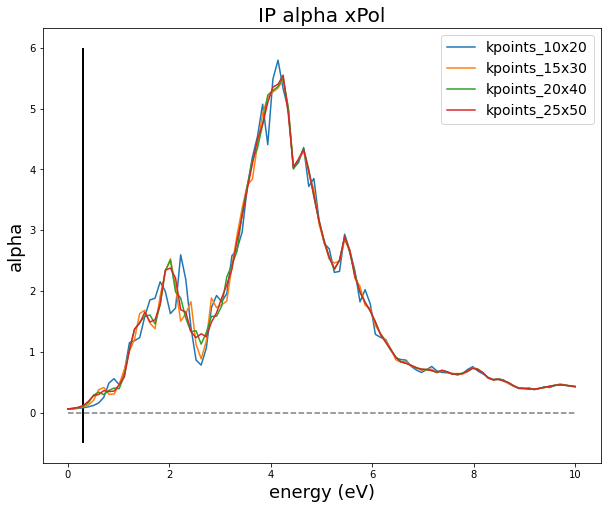

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,6,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha xPol',size=20)
ax.legend(fontsize=14)

In the same way we can compute the polarizability due to a field polarized along the y direction

In [81]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,6] # eV
damping = [0.07,0.07] # eV
BLongDir = [0.0,1.0,0.0]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir)
    idd = 'abs-ip-yPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 2 parallel tasks


In [82]:
#study.runs[0]

In [83]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
delete job_out script: MB_analysis/kpoints_10x20-nbnds_35/job_abs-ip-yPol-kpoints_10x20.out
delete folder: MB_analysis/kpoints_10x20-nbnds_35/abs-ip-yPol-kpoints_10x20
run command: mpirun -np 16 yambo -F abs-ip-yPol-kpoints_10x20.in -J abs-ip-yPol-kpoints_10x20 -C abs-ip-yPol-kpoints_10x20
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_35 ; sbatch job_abs-ip-yPol-kpoints_10x20.sh
delete job_out script: MB_analysis/kpoints_15x30-nbnds_35/job_abs-ip-yPol-kpoints_15x30.out
computation abs-ip-yPol-kpoints_10x20 is running...
delete folder: MB_analysis/kpoints_15x30-nbnds_35/abs-ip-yPol-kpoints_15x30
run command: mpirun -np 16 yambo -F abs-ip-yPol-kpoints_15x30.in -J abs-ip-yPol-kpoints_15x30 -C abs-ip-yPol-kpoints_15x30
slurm submit:  cd MB_analysis/kpoints_15x30-nbnds_35 ; sbatch job_abs-ip-yPol-kpoints_15x30.sh
computation abs-ip-yPol-kpoints_15x30 is running...
computation abs-ip-yPol

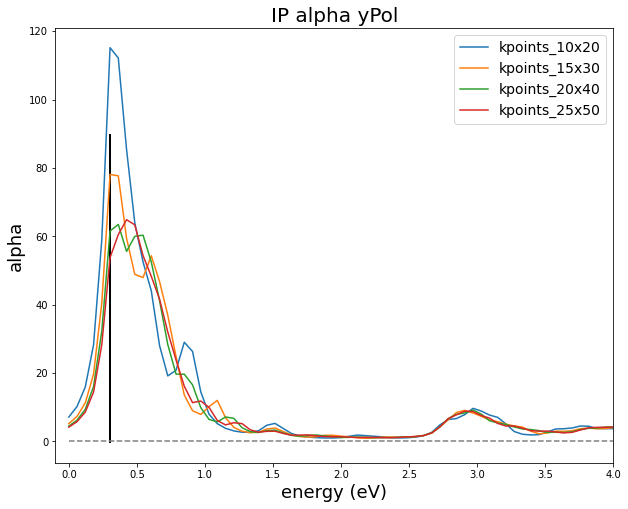

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,90,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-0.1,4)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha yPol',size=20)
ax.legend(fontsize=14)

## IP absorption with local fields

We compute the polarizability along the y direction including the kernel Hartree that accounts for the local field effects

In [114]:
kvalues = [10]

In [115]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,6] # eV
energy_step = 1000
damping = [0.07,0.07] # eV
BSEBands = [20,35]
BLongDir = [0.0,1.0,0.0]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k hartree -y d',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,BSEBands=BSEBands)
    inp.set_array_variables(BLongDir=BLongDir)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')   
    idd = 'abs-hartree-yPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 1 parallel tasks


In [121]:
#study.runs[0]

In [117]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of abs-hartree-yPol-kpoints_10x20
Task [0] ended 
 


In [126]:
#results[0].data['alpha_q1_diago_bse']

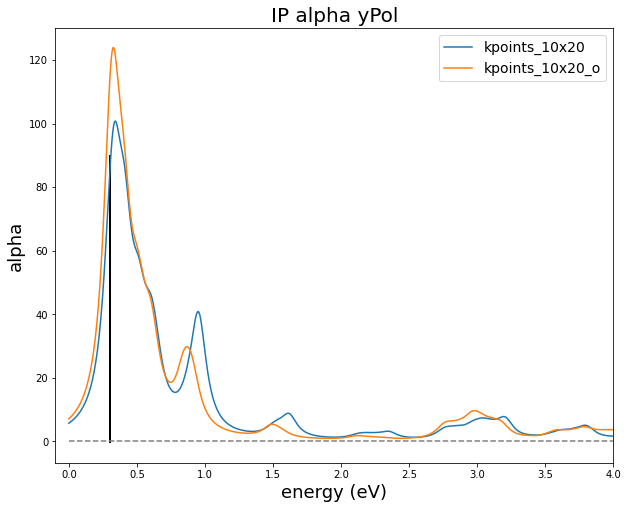

In [128]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_diago_bse']
    energy = data['energy']
    alpha_im = data['eps_imag']
    alpha_o_im = data['eps_o_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
    ax.plot(energy,alpha_o_im,label='kpoints_%sx%s_o'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,90,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-0.1,4)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha yPol',size=20)
ax.legend(fontsize=14)

## BSE Analysis

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.1.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr,clean_restart=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.1.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': False,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We perform the BSE analysis to compute the absorption spectrum and the excitonic energies.

We perform this analysis for various values of the relevant paramters and k-samplings to check the convergence 
of the BSE results. Computations are performed by including a scissor provided by the GW correction at the $\Gamma$ point to the DFT KS energies

In [4]:
ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

start_band,stop_band = 25,26
Gamma_index = 1

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
#ksamplings

Parse file MB_analysis/kpoints_10x20-nbnds_800/pp-G-kpoints_10x20/o-pp-G-kpoints_10x20.qp
Parse file MB_analysis/kpoints_15x30-nbnds_600/pp-G-kpoints_15x30/o-pp-G-kpoints_15x30.qp
Parse file MB_analysis/kpoints_20x40-nbnds_600/pp-G-kpoints_20x40/o-pp-G-kpoints_20x40.qp
Parse file MB_analysis/kpoints_25x50-nbnds_600/pp-G-kpoints_25x50/o-pp-G-kpoints_25x50.qp


### Convergence of the BSEBands and of the BSENGBlk parameter

First we test the effects of the number of BSE bands and of the cutoff in the BSE matrix in the smaller k-sampling.

We start by performing a convergence test on the BSENGBlk parameter with 20 bands (from 15 to 35) in the BSE matrix.

In [36]:
kpoints = '10x20'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = [3.0,4.0] # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [0.,1.,0.]
BSEBands = [15,35]  # [23,28]
BEnRange = [-0.5,4] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
BSSEnTarget = 1.0 # eV Target energy to find eigenvalues 
BSSSlepcMaxIt = 100
damping = [0.1,0.1] # eV

dft_gap = 0.300
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig) #,BSSSlepcMaxIt=BSSSlepcMaxIt
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
#inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  

for bsengblk in BSENGBlk:
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bands_%s-%s'%(bsengblk,BSEBands[0],BSEBands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_pp-ngsblkxp_6.0-bndsrnxp_400'],reformat=False) #,'ndbs_bse'

Initialize a Dataset with 1 parallel tasks


In [37]:
study.ids

['bse-bsengblk_3.0-bands_15-35', 'bse-bsengblk_4.0-bands_15-35']

In [38]:
#study.runs[0]

In [39]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
run performed starting from existing results
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F bse-bsengblk_3.0-bands_15-35.in -J "bse-bsengblk_3.0-bands_15-35,ndb_pp-ngsblkxp_6.0-bndsrnxp_400" -C bse-bsengblk_3.0-bands_15-35
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_800 ; sbatch job_bse-bsengblk_3.0-bands_15-35.sh
computation bse-bsengblk_3.0-bands_15-35 is running...
computation bse-bsengblk_3.0-bands_15-35 ended
Run performed in 02h-32m
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-bsengblk_4.0-bands_15-35
Task [1] ended 
 


In [40]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.457658, 0.594841, 0.651276, 0.727762, 0.731454, 0.792035,
       0.838108, 0.899838, 0.91217 , 0.962202, 0.983905, 1.02755 ,
       1.04962 , 1.064393, 1.066791, 1.173856, 1.174698])

In [41]:
exc_eng = results[1].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.45766 , 0.594881, 0.651284, 0.727766, 0.731463, 0.792045,
       0.838113, 0.89983 , 0.912334, 0.962193])

In [32]:
bind_eng = ksamplings[kpoints]['gw_gap']-exc_eng[0]
bind_eng

0.6838869999999999

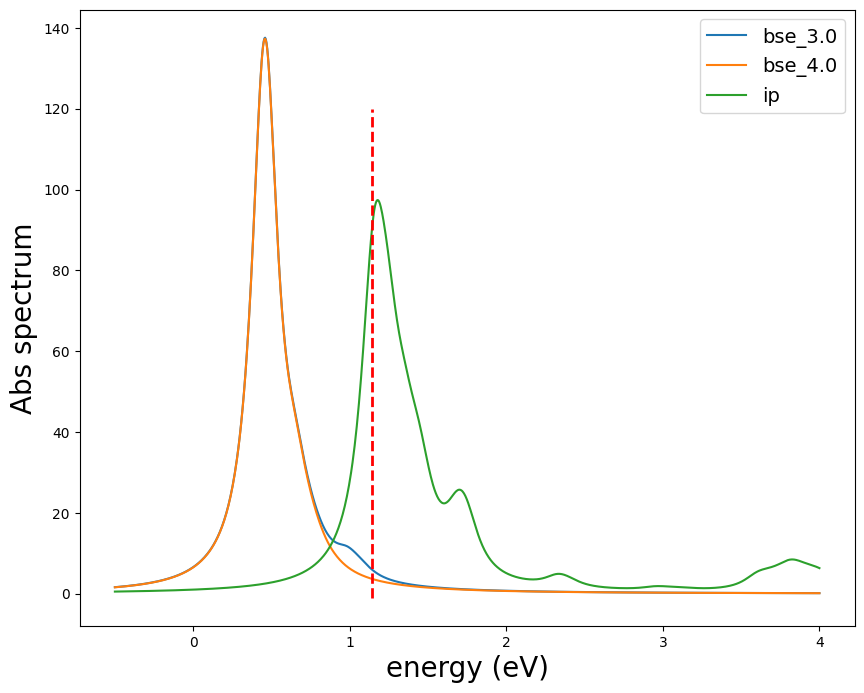

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(BSENGBlk)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%BSENGBlk[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(ksamplings[kpoints]['gw_gap'],-1,120,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
#ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

On the basis of this analysis it turns out BSENGBlk = 3 Ha is sufficient for the convergence of both the excitation energies and of the associated polarizability.

Then we explore the converge on the bands parameter.

In [5]:
kpoints = '10x20'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [0.,1.,0.]
BSEBands = [[15,35],[17,33],[19,31]]  # [23,28]
BEnRange = [-0.5,4] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
#BSSEnTarget = 1.0 # eV Target energy to find eigenvalues 
#BSSSlepcMaxIt = 100
damping = [0.1,0.1] # eV

dft_gap = 0.300
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
#inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  

for bands in BSEBands:
    inp.set_array_variables(BSEBands=bands,BEnSteps=BEnSteps,BSSNEig=BSSNEig) #,BSSSlepcMaxIt=BSSSlepcMaxIt
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bands_%s-%s'%(BSENGBlk,bands[0],bands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_pp-ngsblkxp_6.0-bndsrnxp_400','bse-bsengblk_3.0-bands_15-35'],reformat=False) #,'ndbs_bse'

Initialize a Dataset with 1 parallel tasks


In [6]:
study.ids

['bse-bsengblk_3.0-bands_15-35',
 'bse-bsengblk_3.0-bands_17-33',
 'bse-bsengblk_3.0-bands_19-31']

In [62]:
#study.runs[0]

In [63]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsengblk_3.0-bands_15-35
Task [0] ended 
 
Run the task [1] 
Skip the run of bse-bsengblk_3.0-bands_17-33
Task [1] ended 
 
Run the task [2] 
run performed starting from existing results
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core yambo -F bse-bsengblk_3.0-bands_19-31.in -J "bse-bsengblk_3.0-bands_19-31,ndb_pp-ngsblkxp_6.0-bndsrnxp_400,bse-bsengblk_3.0-bands_15-35" -C bse-bsengblk_3.0-bands_19-31
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_800 ; sbatch job_bse-bsengblk_3.0-bands_19-31.sh
computation bse-bsengblk_3.0-bands_19-31 is running...
computation bse-bsengblk_3.0-bands_19-31 ended
Run performed in 20m-07s
Task [2] ended 
 


In [64]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.457658, 0.594841, 0.651276, 0.727762, 0.731454, 0.792035,
       0.838108, 0.899838, 0.91217 , 0.962202, 0.983905, 1.02755 ,
       1.04962 , 1.064393, 1.066791, 1.173856, 1.174698])

In [65]:
exc_eng = results[1].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.459429, 0.594857, 0.651964, 0.727961, 0.731457, 0.792179,
       0.838111, 0.899866, 0.91223 , 0.962202, 0.986569, 1.027551,
       1.04964 , 1.064409, 1.067023, 1.17386 , 1.174702])

In [66]:
exc_eng = results[2].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.46048 , 0.594867, 0.652384, 0.728087, 0.731464, 0.792269,
       0.838114, 0.899883, 0.912322, 0.962205, 0.988145, 1.027553,
       1.049654, 1.064429, 1.067182, 1.173864, 1.174702])

In [58]:
bind_eng = ksamplings[kpoints]['gw_gap']-exc_eng[0]
bind_eng

0.6821179999999999

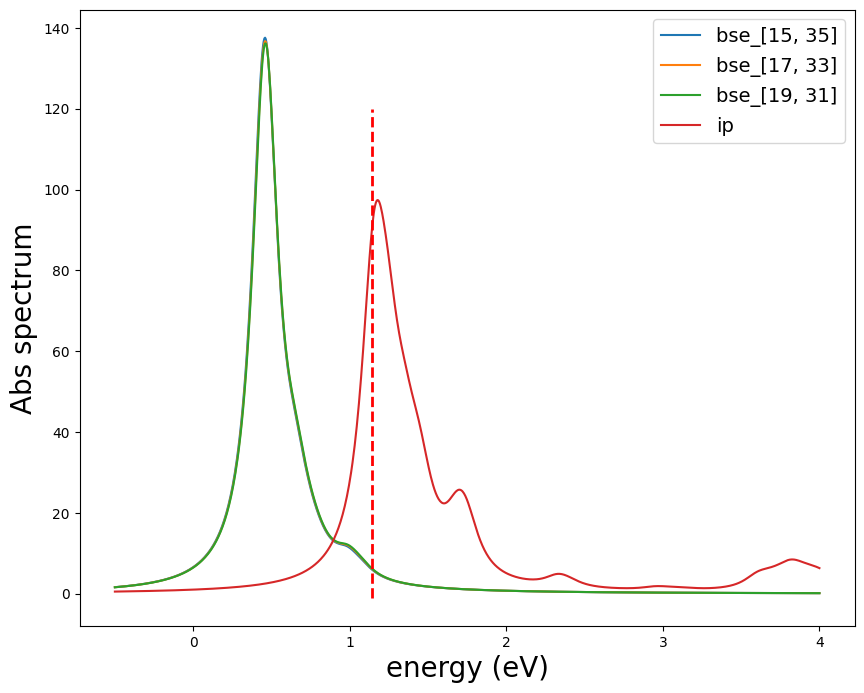

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(BSEBands)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%BSEBands[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(ksamplings[kpoints]['gw_gap'],-1,120,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
#ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

### Convergence in terms of the k-sampling

We investigate the convergence of the BSE spectrum and excitonic energies in function of the k-points samplings.

In [7]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.1.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr) #,clean_restart=False
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.1.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

In [8]:
ksamplings = {'10x20': {'folder':'kpoints_10x20-nbnds_800','npoints':66},
             '15x30': {'folder':'kpoints_15x30-nbnds_600','npoints':128},
             '20x40': {'folder':'kpoints_20x40-nbnds_600','npoints':231},
             '25x50': {'folder':'kpoints_25x50-nbnds_600','npoints':338}
            }

start_band,stop_band = 25,26
Gamma_index = 1

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
#ksamplings

Parse file MB_analysis/kpoints_10x20-nbnds_800/pp-G-kpoints_10x20/o-pp-G-kpoints_10x20.qp
Parse file MB_analysis/kpoints_15x30-nbnds_600/pp-G-kpoints_15x30/o-pp-G-kpoints_15x30.qp
Parse file MB_analysis/kpoints_20x40-nbnds_600/pp-G-kpoints_20x40/o-pp-G-kpoints_20x40.qp
Parse file MB_analysis/kpoints_25x50-nbnds_600/pp-G-kpoints_25x50/o-pp-G-kpoints_25x50.qp


For this analysis we use the converged values

BSENGBlk = 3.0 # Ha  
BSEBands = [19,31]

In [9]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [0.,1.,0.]
BSEBands = [19,31]  
BEnRange = [-0.5,4] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
#BSSEnTarget = 1.0 # eV Target energy to find eigenvalues 
#BSSSlepcMaxIt = 100
damping = [0.1,0.1] # eV

dft_gap = 0.300

study = D.Dataset(num_tasks=4,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    scissor = ksamplings[kpoints]['gw_gap'] - dft_gap
    inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
    inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
    #inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    #inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
    inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig) #,BSSSlepcMaxIt=BSSSlepcMaxIt
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],kpoints)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_pp-ngsblkxp_6.0-bndsrnxp_400','bse-bsengblk_3.0-bands_19-31'],reformat=False) #,'ndbs_bse'

Initialize a Dataset with 4 parallel tasks


In [10]:
study.ids

['bse-bsengblk_3.0-bands_19-31-kpoints_10x20',
 'bse-bsengblk_3.0-bands_19-31-kpoints_15x30',
 'bse-bsengblk_3.0-bands_19-31-kpoints_20x40',
 'bse-bsengblk_3.0-bands_19-31-kpoints_25x50']

In [80]:
#study.runs[1]

In [11]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1, 2, 3]] 

Run the task [0, 1, 2, 3] 
Skip the run of bse-bsengblk_3.0-bands_19-31-kpoints_15x30
Skip the run of bse-bsengblk_3.0-bands_19-31-kpoints_10x20
Skip the run ofSkip the run of bse-bsengblk_3.0-bands_19-31-kpoints_25x50 
bse-bsengblk_3.0-bands_19-31-kpoints_20x40
Task [0, 1, 2, 3] ended 
 


In [23]:
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
kpoints = np.arange(1,len(ksamplings.keys())+1)
for ind in range(len(ksamplings.keys())):
    excitations.append(results[ind].data['Esort_q1_slepc_bse']['energy'][exc_ind])
excitations,kpoints

([0.46048, 0.501294, 0.523548, 0.533724], array([1, 2, 3, 4]))

In [29]:
list(ksamplings.keys())

['10x20', '15x30', '20x40', '25x50']

(0.42, 0.55)

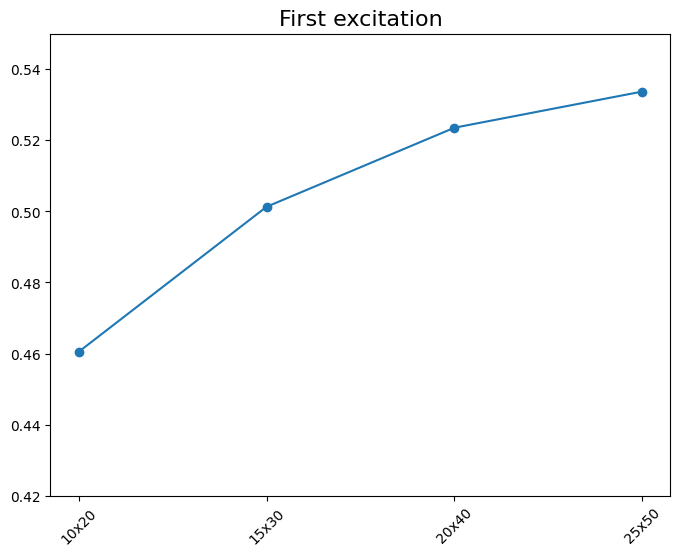

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations)
labels = list(ksamplings.keys())
plt.xticks(kpoints, labels, rotation=45,size=10)
ax.set_title('First excitation',size=16)
ax.set_ylim(0.42,0.55)

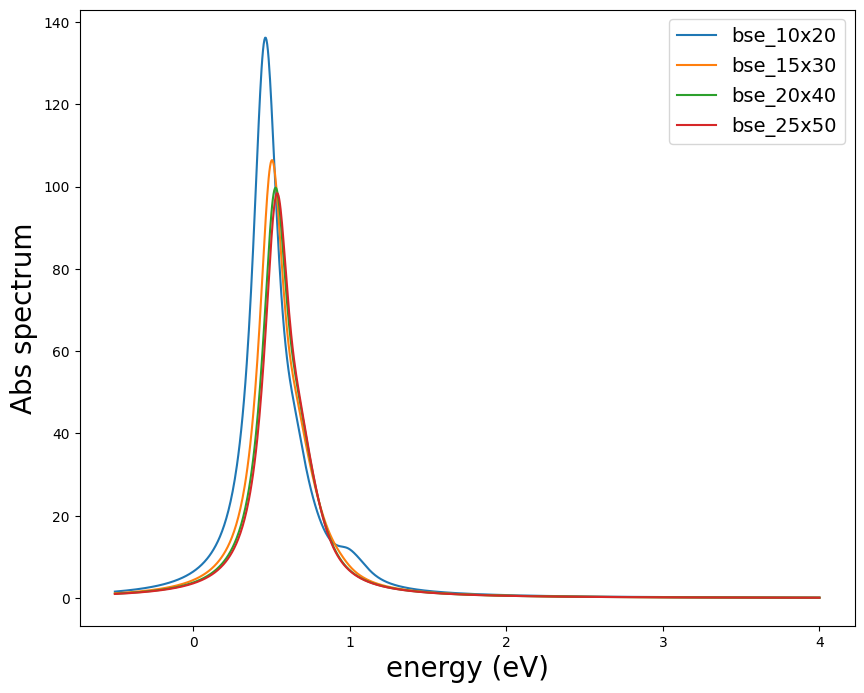

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(4):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%list(ksamplings.keys())[ind])
#eps_o_im = data['alpha_o_imag']
#ax.plot(energy,eps_o_im,label='ip') 
#ax.vlines(ksamplings[kpoints]['gw_gap'],-1,120,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
#ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)